# Machine Learning project Multilayer Perceptron


# 1. Overview
## 1-1. Multilayer perceptron

[多層パーセプトロンとは zero2one](https://zero2one.jp/ai-word/multilayer-perceptron/)
[多層パーセプトロンについて解説 パラメータ](https://www.tech-teacher.jp/blog/mlp/)

## 1-2. Feedforward

入力ベクトル $x$ に対して、$l$ 層のニューロンネットワークを考える

第 $i$ 層の出力を $a^{(i)}$ とし、重み行列を $W^{(i)}$、バイアスベクトルを $b^{(i)}$ 、活性化関数を $f$ とすると
各層の出力は以下のように計算できる：
$a^{(i)} = f(z^{(i)}) = f(W^{(i)}a^{(i-1)} + b^{(i)})$

ここで、$a^{(0)} = x$ （入力層）
最終的な出力は $a^{(l)}$ となる

## 1-3. Backpropagation

バックプロパゲーションは、ネットワークの誤差を最小化するために使用される学習アルゴリズム
出力層での実際の出力と期待される出力の差（誤差）を計算
この誤差を出力層から入力層に向かって逆伝播する
各層の重みとバイアスの勾配（誤差への寄与度）を計算

損失関数を $L$ とし、$\delta^{(i)} = \frac{\partial L}{\partial z^{(i)}}$ を第 $i$ 層の誤差としたとき、

出力層（第 $l$ 層）の誤差：
$\delta^{(l)} = \nabla_a L \odot f'(z^{(l)})$

ここで $\odot$ はアダマール積（要素ごとの積）を表す

隠れ層の誤差（$i = l-1, ..., 2, 1$）：
$\delta^{(i)} = ((W^{(i+1)})^T \delta^{(i+1)}) \odot f'(z^{(i)})$

重みとバイアスの勾配：
$\frac{\partial L}{\partial W^{(i)}} = \delta^{(i)}(a^{(i-1)})^T$
$\frac{\partial L}{\partial b^{(i)}} = \delta^{(i)}$

[バックプロパゲーション（誤差逆伝搬法）](https://imagingsolution.net/deep-learning/backpropagation/)
[誤差逆伝播法/machine-learning-lecture-backpropagation](https://speakerdeck.com/monochromegane/machine-learning-lecture-backpropagation)
[誤差逆伝播法（バックプロパゲーション）とは](https://rikeiminimalist.blog.jp/archives/5995253.html)
[誤差逆伝播法（バックプロパゲーション）](https://rikeiminimalist.blog.jp/archives/6579606.html)

## 1-4. Gradient descent

バックプロパゲーションで計算された勾配を使用してネットワークのパラメータを更新する最適化アルゴリズム
計算された勾配の方向に沿ってパラメータを調整
学習率（learning rate）を用いて、パラメータの更新量を制御
目的関数（通常は誤差関数）の最小値に向かってパラメータを徐々に改善していく

学習率を $\eta$ とすると、パラメータの更新は：
$W^{(i)} = W^{(i)} - \eta \frac{\partial L}{\partial W^{(i)}}$
$b^{(i)} = b^{(i)} - \eta \frac{\partial L}{\partial b^{(i)}}$

これを全ての層 $i = 1, ..., l$ に対して適用

# 2. 解説

## 2-1. データ分割
### 2-1-1) データの整形

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

from srcs.modules.tools import normalize

csv_path = "../data/data.csv"
df = pd.read_csv(csv_path, header=None)
print(df.head())

         0  1      2      3       4       5        6        7       8   \
0    842302  M  17.99  10.38  122.80  1001.0  0.11840  0.27760  0.3001   
1    842517  M  20.57  17.77  132.90  1326.0  0.08474  0.07864  0.0869   
2  84300903  M  19.69  21.25  130.00  1203.0  0.10960  0.15990  0.1974   
3  84348301  M  11.42  20.38   77.58   386.1  0.14250  0.28390  0.2414   
4  84358402  M  20.29  14.34  135.10  1297.0  0.10030  0.13280  0.1980   

        9   ...     22     23      24      25      26      27      28      29  \
0  0.14710  ...  25.38  17.33  184.60  2019.0  0.1622  0.6656  0.7119  0.2654   
1  0.07017  ...  24.99  23.41  158.80  1956.0  0.1238  0.1866  0.2416  0.1860   
2  0.12790  ...  23.57  25.53  152.50  1709.0  0.1444  0.4245  0.4504  0.2430   
3  0.10520  ...  14.91  26.50   98.87   567.7  0.2098  0.8663  0.6869  0.2575   
4  0.10430  ...  22.54  16.67  152.20  1575.0  0.1374  0.2050  0.4000  0.1625   

       30       31  
0  0.4601  0.11890  
1  0.2750  0.08902  
2  0.

In [2]:
# load_wdbc_data

columns = ['id', 'diagnosis']
# 特徴量の名前リスト
features = [
    'radius',
    'texture',
    'perimeter',
    'area',
    'smoothness',
    'compactness',
    'concavity',
    'concavePoints',
    'symmetry',
    'fractal_dimension'
]
# 統計量の名前リスト
stats = ['mean', 'stderr', 'worst']

for feature, stat in product(features, stats):
    columns.append(f"{feature}_{stat}")

df.columns = columns
print(df.head())
print(df.info())

         id diagnosis  radius_mean  radius_stderr  radius_worst  texture_mean  \
0    842302         M        17.99          10.38        122.80        1001.0   
1    842517         M        20.57          17.77        132.90        1326.0   
2  84300903         M        19.69          21.25        130.00        1203.0   
3  84348301         M        11.42          20.38         77.58         386.1   
4  84358402         M        20.29          14.34        135.10        1297.0   

   texture_stderr  texture_worst  perimeter_mean  perimeter_stderr  ...  \
0         0.11840        0.27760          0.3001           0.14710  ...   
1         0.08474        0.07864          0.0869           0.07017  ...   
2         0.10960        0.15990          0.1974           0.12790  ...   
3         0.14250        0.28390          0.2414           0.10520  ...   
4         0.10030        0.13280          0.1980           0.10430  ...   

   concavity_worst  concavePoints_mean  concavePoints_stderr  

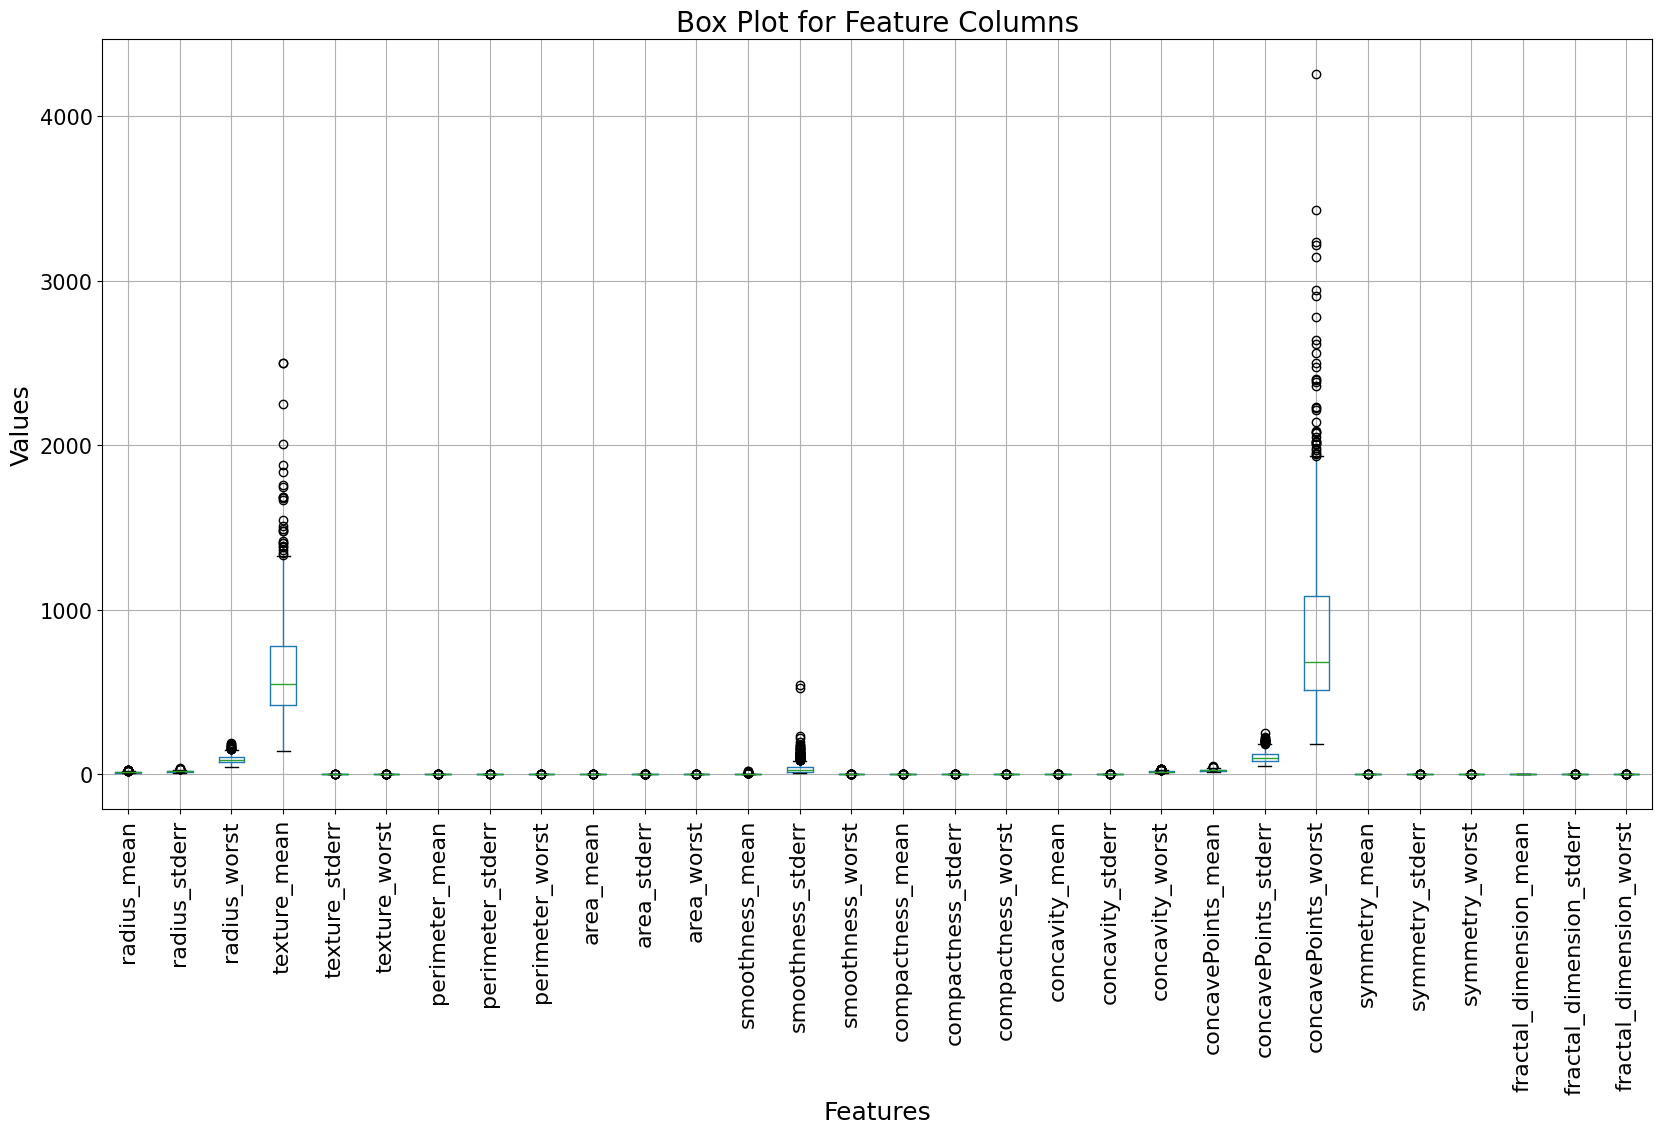

In [3]:
def check_outliers_boxplot(df, columns):
    plt.figure(figsize=(20, 10))
    df[columns].boxplot()

    plt.title("Box Plot for Feature Columns", fontsize=20)

    plt.xticks(rotation=90, fontsize=16)
    plt.yticks(fontsize=15)

    plt.xlabel('Features', fontsize=18)
    plt.ylabel('Values', fontsize=18)

    plt.show()


# 分布を評価
feature_columns = [col for col in df.columns if col not in ['id', 'diagnosis']]
check_outliers_boxplot(df, feature_columns)

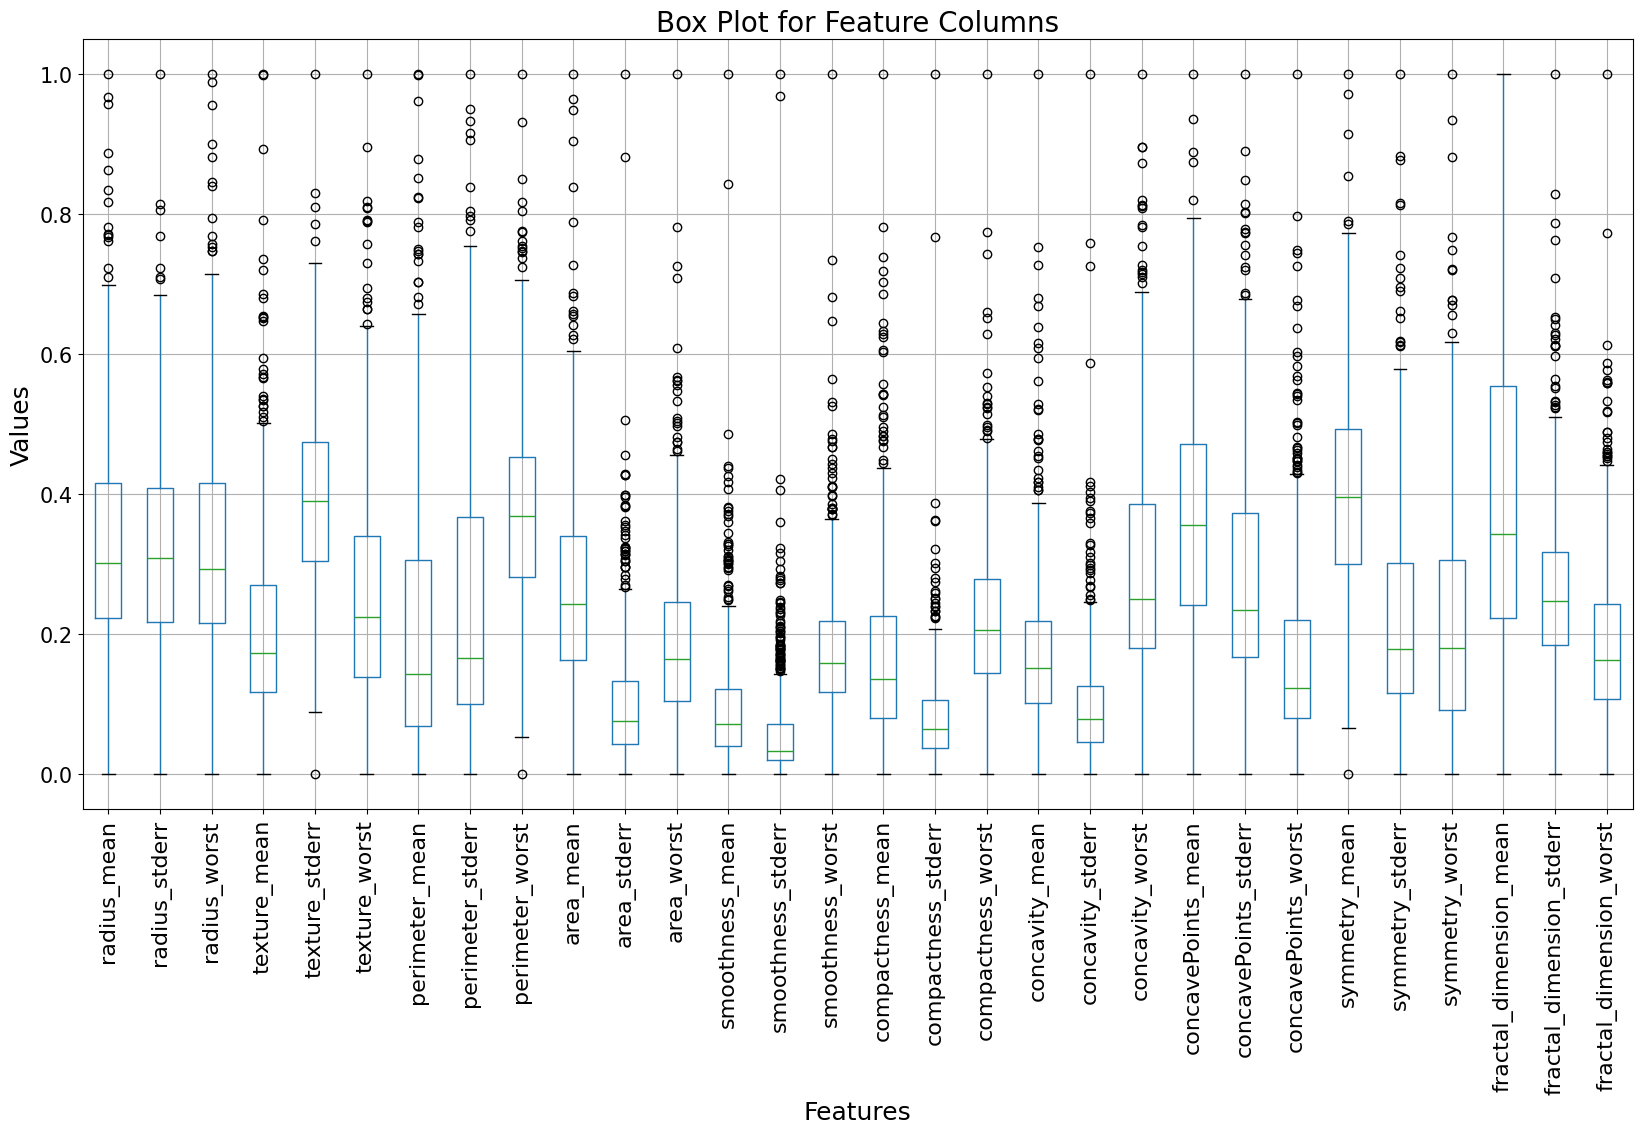

In [4]:
df_norm = normalize(df, feature_columns)
check_outliers_boxplot(df_norm, feature_columns)

### 2-1-2) 分割

In [5]:
import sys
from srcs import dataloader, train, predict
from srcs.modules.plot import plot_multiple_models

In [6]:
sys.argv = [
    'dataloader.py',
    '--dataset_path',   '../data/data.csv',
    '--train_size',     '0.8',
    '--shuffle',        'true',
    '--save_npz',       'false',
    '--save_dir',       '../data',
    # '--save_npz', 'true',
]
args = dataloader.parse_arguments()
_, _, _, _ = dataloader.main(
    csv_path=args.dataset_path,
    train_size=args.train_size,
    shuffle=args.shuffle,
    save_npz=args.save_npz,
    save_dir=args.save_dir,
    random_state=42
)


[Loading]
Data_train data saved to /app/data/data_train.csv
Data_test data saved to /app/data/data_test.csv


## 2-2. 訓練


[Training]

Metrics: 
 Train [Accuracy:0.9918, Precision:1.0000, Recall:0.9781, F1:0.9889]
 Valid [Accuracy:0.9889, Precision:0.9706, Recall:1.0000, F1:0.9851]
Model data saved to /app/data/model.pkl
Metrics saved to /app/data/metrics.npz


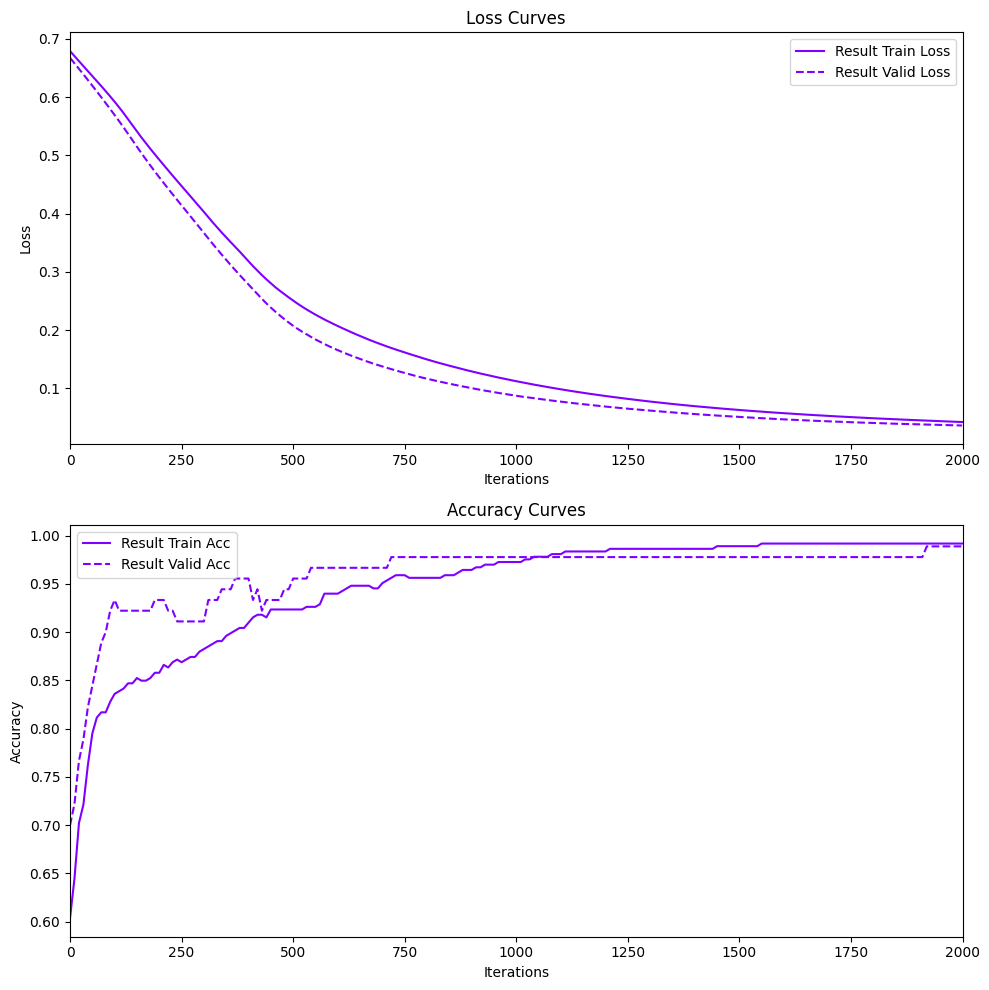

In [7]:
sys.argv = [
    'train.py',
    '--dataset_path',       '../data/data_train.csv',
    '--hidden_features',    '50 30',
    '--epochs',             '2000',
    '--learning_rate',      '0.0001',
    '--optimizer',          'Adam',
    '--verbose',            'false',
    '--plot',               'false',
    '--metrics_interval',   '10',
    '--save_dir',           '../data',
]
args = train.parse_arguments()
_, iterations, train_losses, train_accs, valid_losses, valid_accs = train.main(
    dataset_path=args.dataset_path,
    hidden_features=args.hidden_features,
    epochs=args.epochs,
    learning_rate=args.learning_rate,
    weight_decay=args.weight_decay,
    optimp_str=args.optimizer,
    verbose=args.verbose,
    plot=args.plot,
    metrics_interval=args.metrics_interval,
    patience=args.patience,
    save_dir=args.save_dir,
)

models_results = []
models_results.append({
    'name'          : "Result",
    'iterations'    : iterations,
    'train_losses'  : train_losses,
    'train_accs'    : train_accs,
    'valid_losses'  : valid_losses,
    'valid_accs'    : valid_accs
})

plot_multiple_models(max_itr=2000, models_results=models_results)

## 2-3. 予測

In [8]:
sys.argv = [
    'predict.py',
    '--model_path',     '../data/model.pkl',
    '--dataset_path',   '../data/data_test.csv',
]
args = predict.parse_arguments()
_ = predict.main(
    model_path=args.model_path,
    dataset_path=args.dataset_path,
)



[Prediction]
 Predicting WDBC...
 Pred  [Accuracy:0.9469, Precision:0.9500, Recall:0.9048, F1:0.9268]
